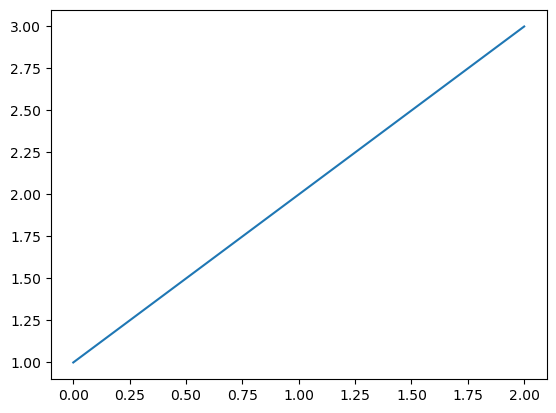

In [1]:
import matplotlib.pyplot as plt
plt.plot([1,2,3])

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
from torch.distributions import MultivariateNormal
from torch.distributions.kl import kl_divergence
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid


In [3]:
# define data transformation pipeline

transform = transforms.Compose([transforms.ToTensor()]) 

path = './data'

train_dataset = MNIST(path,transform=transform,download=True)
test_dataset = MNIST(path,transform=transform,download=True)

# set up data loaders

batch_size=100
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 29699949.03it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35172965.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27593698.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8444383.32it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
image = next(iter(train_loader))

In [5]:
image[0].shape

torch.Size([100, 1, 28, 28])

In [6]:
x = image[0].reshape(-1,28*28)

In [7]:
x.shape

torch.Size([100, 784])

In [8]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

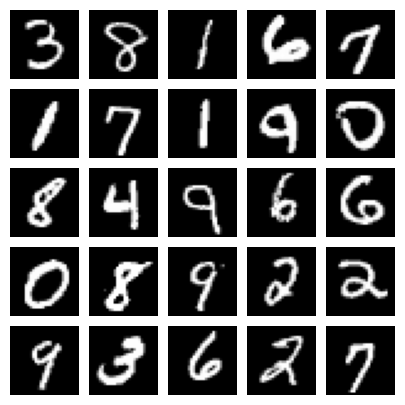

In [9]:
num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5,5))
grid = ImageGrid(fig,111,nrows_ncols=(5,5), axes_pad=0.1)

for ax, im in zip(grid,sample_images):
    ax.imshow(im,cmap='gray')
    ax.axis('off')

In [10]:
class Encoder(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,latent_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,latent_dim)
        
        self.mean_layer = nn.Linear(latent_dim,2)
        self.logvar_layer = nn.Linear(latent_dim,2)
        
    def forward(self,x):
        
        x = self.fc1(x)
        x = F.leaky_relu(x,0.2)
        x = self.fc2(x)
        x = F.leaky_relu(x,0.2)
        
        mean = self.mean_layer(x)

        logvar = self.logvar_layer(x)
        
        return mean, logvar
        

In [11]:
class Decoder(nn.Module):
    
    def __init__(self,latent_dim,hidden_dim,input_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(2,latent_dim)
        self.fc2 = nn.Linear(latent_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,input_dim)
        
    def forward(self,u):
        
        u = self.fc1(u)
        u = F.leaky_relu(u,0.2)
        u = self.fc2(u)
        u = F.leaky_relu(u,0.2)
        u = self.fc3(u)
        
        z = F.sigmoid(u).to(torch.float)
        
        return z
        

In [12]:
class VAE(nn.Module):
    
    def __init__(self,input_dim=784,hidden_dim=400,latent_dim=200):
        super().__init__()
        
        self.encoder = Encoder(input_dim,hidden_dim,latent_dim)
        self.decoder = Decoder(latent_dim,hidden_dim,input_dim)
        
    def reparametrize(self,mean,var):
        epsilon = torch.randn_like(var)

        z = mean + torch.sqrt(var) * epsilon
        return z
    
    def forward(self,x):
        
        mean, logvar = self.encoder(x)
        
        u = self.reparametrize(mean,torch.exp(logvar))
        z = self.decoder(u)
        
        return z, mean, logvar        

In [13]:
vae = VAE()

In [14]:
z,mean,logvar = vae(x)

In [15]:
def loss_function(x,z,mean,logvar):
    reconstruction_loss = F.binary_cross_entropy(z,x,reduction='sum')
    KL_div =  - 0.5 * torch.sum(1+ logvar - mean**2 - torch.exp(logvar))
    
    return reconstruction_loss + KL_div

In [16]:
F.binary_cross_entropy(z,x,reduction='sum')

tensor(54525.1797, grad_fn=<BinaryCrossEntropyBackward0>)

In [17]:
- 0.5 * torch.sum(1+ logvar - mean**2 - torch.exp(logvar))

tensor(0.9064, grad_fn=<MulBackward0>)

In [18]:
optimizer = Adam(vae.parameters(),lr=1e-3)

In [19]:
epochs = 50
for e in range(epochs):
    overall_loss = 0.0
    for i,img in enumerate(train_loader):
        
        x = img[0].reshape(-1,28*28)

        z,mean,logvar = vae(x)
        
        optimizer.zero_grad()

        loss = loss_function(x,z,mean,logvar)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", e + 1, "\tAverage Loss: ", overall_loss/(i*batch_size))

        
  

	Epoch 1 	Average Loss:  179.96988227449395
	Epoch 2 	Average Loss:  162.0726799548727
	Epoch 3 	Average Loss:  157.66033599293092
	Epoch 4 	Average Loss:  155.14499476666842
	Epoch 5 	Average Loss:  153.56158418327422
	Epoch 6 	Average Loss:  152.25250422253234
	Epoch 7 	Average Loss:  151.05972863300815
	Epoch 8 	Average Loss:  150.27382545127296
	Epoch 9 	Average Loss:  149.3993869176492
	Epoch 10 	Average Loss:  148.74057737831282
	Epoch 11 	Average Loss:  148.21751806396077
	Epoch 12 	Average Loss:  147.5249995272068
	Epoch 13 	Average Loss:  147.14946926518155
	Epoch 14 	Average Loss:  146.77820868439588
	Epoch 15 	Average Loss:  146.34517082507304
	Epoch 16 	Average Loss:  145.99321101575543
	Epoch 17 	Average Loss:  145.56703335311457
	Epoch 18 	Average Loss:  145.3022927535476
	Epoch 19 	Average Loss:  145.0011625984714
	Epoch 20 	Average Loss:  144.72344257029945
	Epoch 21 	Average Loss:  144.45674796535894
	Epoch 22 	Average Loss:  144.1538368472193
	Epoch 23 	Average Loss: 

In [20]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float)
    x_decoded = vae.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

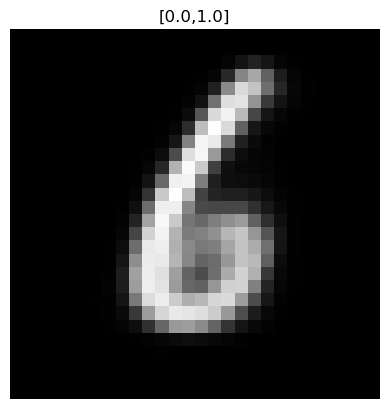

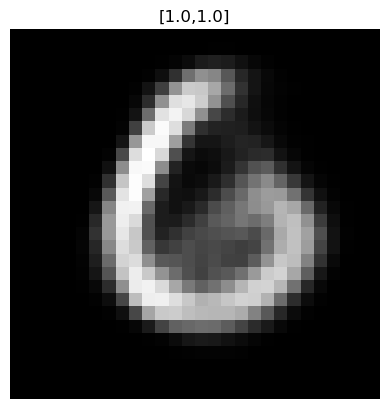

(None, None)

In [21]:
generate_digit(0.0,1.0),generate_digit(1.0,1.0)

In [22]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float)
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

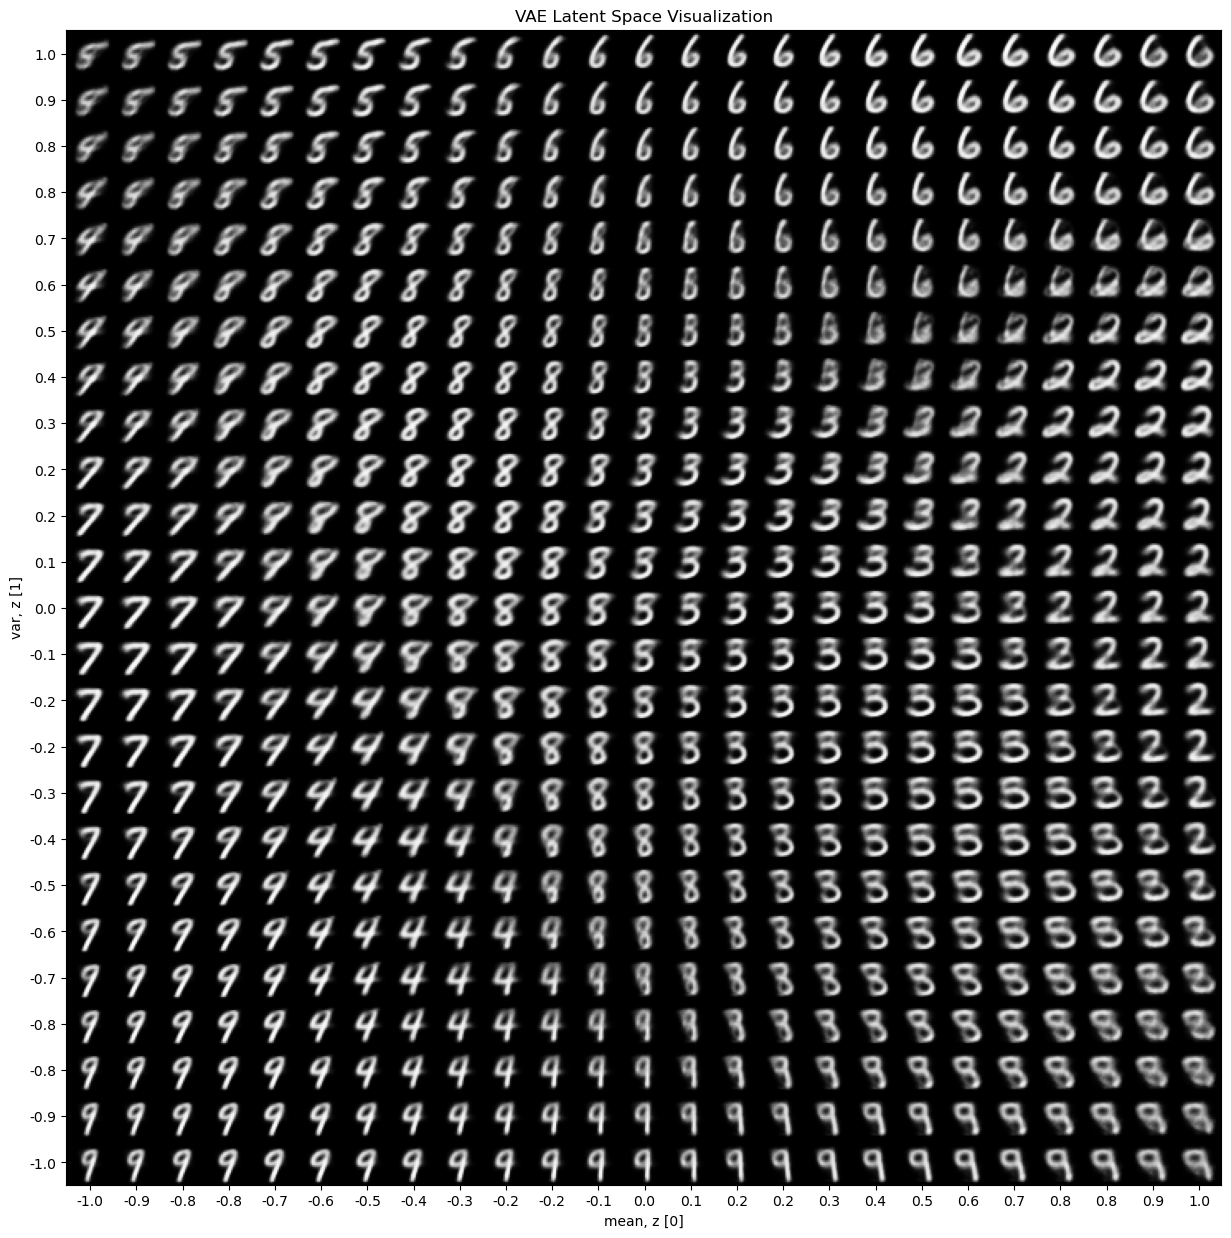

In [23]:
plot_latent_space(vae, scale=1.0)

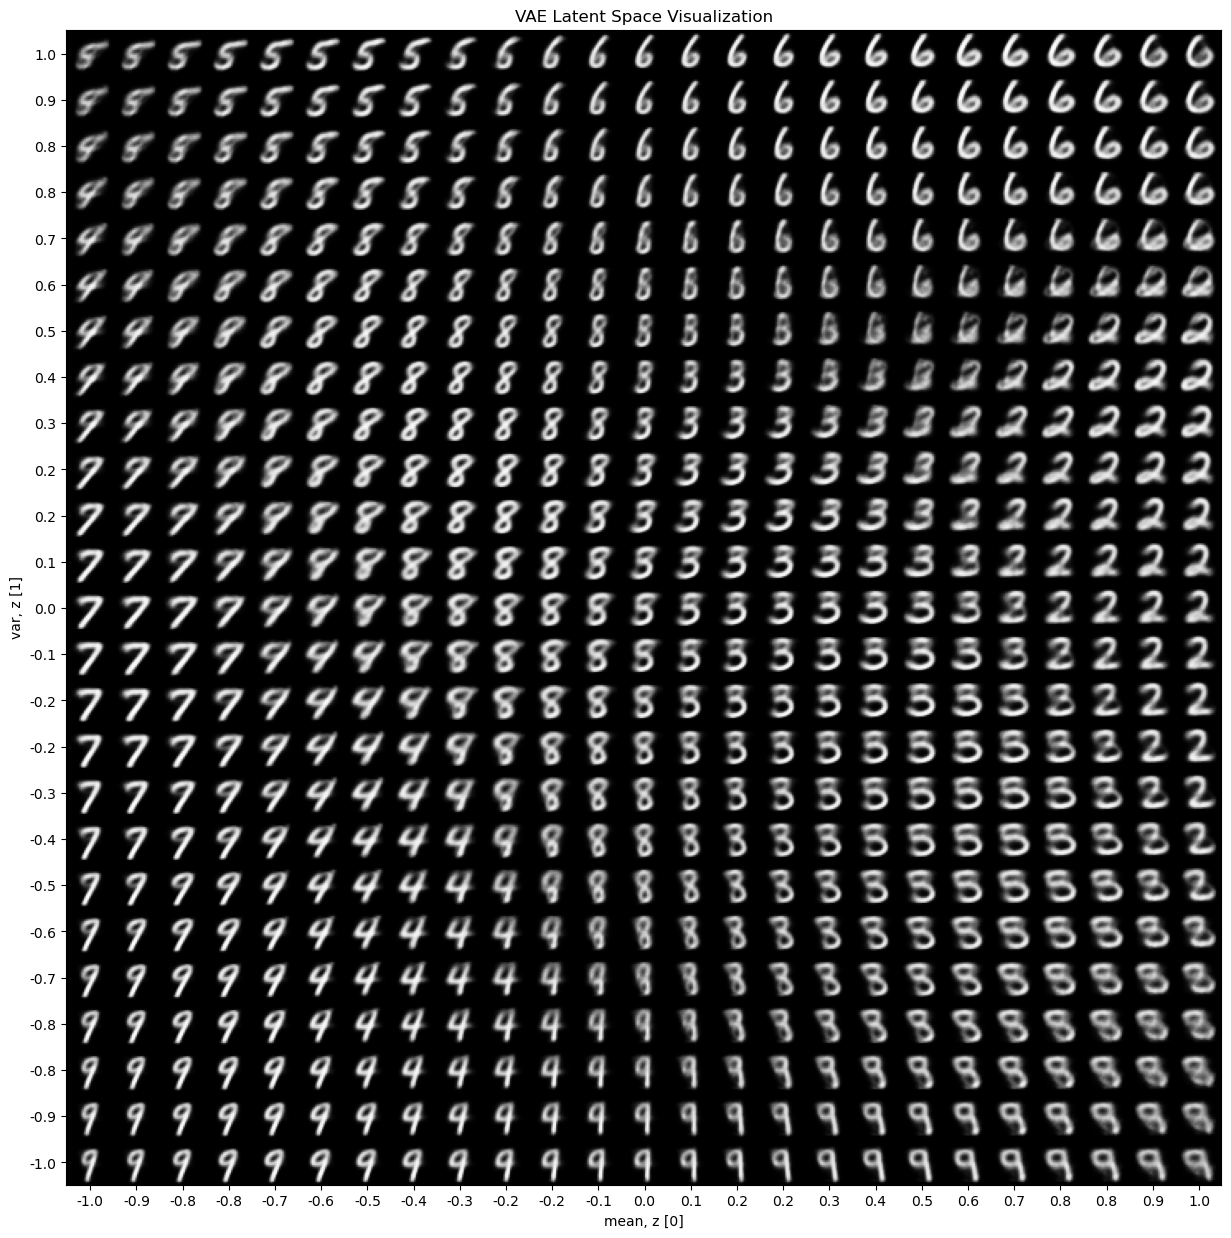

In [24]:
plot_latent_space(vae, scale=1.0)

In [25]:
epsilon = torch.randn(20,2)

In [26]:
x = next(iter(test_loader))

In [27]:
x = x[0][10]

In [28]:
x = x.reshape(28,28)

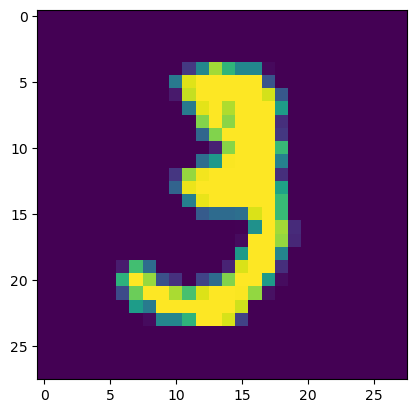

In [29]:
plt.imshow(x)

In [30]:
x = x.reshape(1,1,28*28)

In [31]:
x_hat,mean,logvar = vae(x)

In [39]:
logvar

tensor([[[-7.4420, -7.6125]]], grad_fn=<ViewBackward0>)

In [32]:
latent_samples = mean + epsilon*torch.exp(logvar)

In [33]:
latent_samples

tensor([[[0.1168, 0.3501],
         [0.1164, 0.3497],
         [0.1172, 0.3498],
         [0.1171, 0.3493],
         [0.1166, 0.3489],
         [0.1161, 0.3492],
         [0.1162, 0.3487],
         [0.1171, 0.3484],
         [0.1164, 0.3504],
         [0.1162, 0.3504],
         [0.1161, 0.3494],
         [0.1169, 0.3495],
         [0.1174, 0.3498],
         [0.1164, 0.3494],
         [0.1158, 0.3495],
         [0.1158, 0.3497],
         [0.1172, 0.3497],
         [0.1165, 0.3496],
         [0.1157, 0.3491],
         [0.1168, 0.3496]]], grad_fn=<AddBackward0>)

In [34]:
imgs = vae.decoder(latent_samples).detach()

In [35]:
imgs = imgs.reshape(20,28,28)

In [36]:
imgs[0].shape

torch.Size([28, 28])

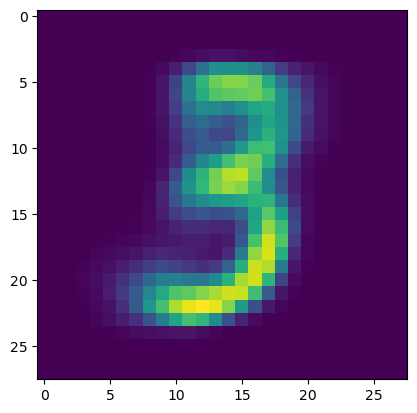

In [37]:
plt.imshow(imgs[11])

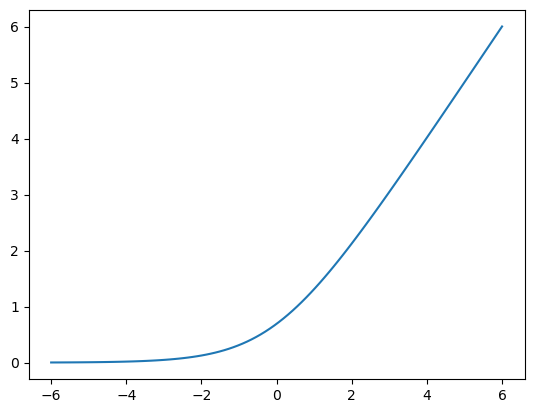

In [38]:
x = np.linspace(-6,6,100)
plt.plot(x,np.log(1+np.exp(x)))